# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2024-07-12


In [2]:
# Importing essential libraries for data manipulation, mathematical operations, and plotting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from pathlib import Path
import os

from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

# Importing custom libraries specific to this analysis
import lib.NetAnalysis as na
import lib.funcs_ko as funcs_ko
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as fig_func
import lib.funcs_general as funcs_general

# Setting up matplotlib for LaTeX-style text rendering
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Uncomment the following lines during development for automatic module reloading
%load_ext autoreload
%autoreload 2


# Information and Data Loading


In [14]:
# Define the base directory for code and data using pathlib for better path handling
base_dir = Path("/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference")
path = base_dir / "GRN_Inference_CODE"
path_data = base_dir / "DATA"
figs_path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG"



In [4]:
# genes of OUR dataset
genes_reference = np.loadtxt(path_data/"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_reference if x not in naive and x not in formative_early and x not in formative_late]


In [5]:
index_steps = np.loadtxt("/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/Code/Work/GE_data/time_sep.txt").astype(int)
# Number of cells in each time step
print(index_steps)

[2025 2532 2025 1765 1547]


In [6]:
# load the input data
CO_df_wt_input = pd.read_csv(path_data / "CO_df_wt_input_all_genes.csv")
print(CO_df_wt_input.shape)

# load the output data
CO_df_tKO_input = pd.read_csv(path_data / "CO_df_triple_KO_input_all_genes.csv")
print(CO_df_tKO_input.shape)

# pseudotime for the cell (already ordered)
PST_df_lN = pd.read_csv(path_data/'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt', 
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"]) # pst for LogNorm 
print("Number of cells in PST df: ", PST_df_lN.shape[0])
PST_df_lN = PST_df_lN.sort_values(by=['pst'])
pst_wt_input = PST_df_lN["pst"]


(9696, 2078)
(9696, 2078)
Number of cells in PST df:  9696


In [7]:
time_sep = np.loadtxt(path_data/"GE_data/time_sep.txt").astype(np.int32)
print("Shape of the time points cells", time_sep.sum())

time_points = [0, 6, 12, 24, 48]  

# load raw data
df_lN_all = pd.read_csv(path_data / "GE_data/logNorm.csv", header=0, index_col=0, sep=",")
df_lN_all.index.name = None
df_lN_all.head()
print("shape of the raw data:", df_lN_all.shape)

# select just the Relevant genes (rows with index contained in genes_relevant)
df_lN = df_lN_all.copy() #loc[genes_reference].reindex(genes_reference)
print("shape of the selected data:", df_lN.shape)


Shape of the time points cells 9894
shape of the raw data: (13833, 9894)
shape of the selected data: (13833, 9894)


In [8]:
# Calcola i time point basandoti su time_sep
time_labels = np.repeat(time_points, time_sep)

# Controlla se il numero totale di colonne nel dataframe corrisponde
# alla lunghezza dell'array time_labels
if len(time_labels) != df_lN.shape[1]:
    raise ValueError("The number of columns in the dataframe does not match the length of the time_labels array")

# Assegna i time point come una nuova riga nel dataframe
df_lN.loc['TimePoint'] = time_labels

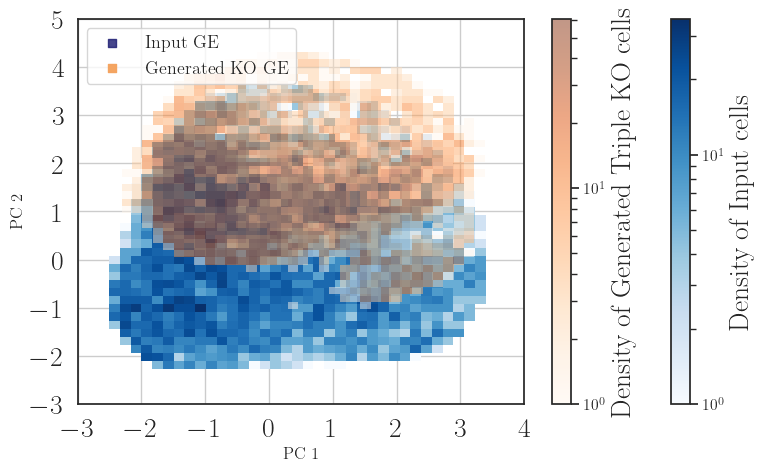

In [9]:
# compute PCA
pca_wt_input = PCA(n_components=2)
pca_wt_input.fit(CO_df_wt_input)

co_wt_input_transformed = pca_wt_input.transform(CO_df_wt_input)
principalDf_wt_input = pd.DataFrame(data=co_wt_input_transformed, columns=['PC1', 'PC2'])
co_wt_transf = pca_wt_input.transform(CO_df_tKO_input)
principalDf_co_wt = pd.DataFrame(data=co_wt_transf, columns=['PC1', 'PC2'])

import matplotlib.colors as colors

plt.figure(figsize=(9, 5))

# Creazione dell'istogramma 2D
pcm_input = plt.hist2d(principalDf_wt_input['PC1'], principalDf_wt_input['PC2'], bins=35, cmap='Blues', norm=colors.LogNorm(), alpha=1)
pcm_ko_generated = plt.hist2d(principalDf_co_wt['PC1'], principalDf_co_wt['PC2'], bins=35, cmap='Oranges', norm=colors.LogNorm(), alpha=0.48)
cb_input = plt.colorbar(pcm_input[3])  # Mostra la barra dei colori
cb_input.set_label('Density of Input cells', fontsize=20)
cb_generated = plt.colorbar(pcm_ko_generated[3])  # Mostra la barra dei colori
cb_generated.set_label('Density of Generated Triple KO cells', fontsize=20)

# cb_generated.set_label('density', fontsize=20)
plt.scatter([], [], label='Input GE',  color="midnightblue" , s=30, marker='s', alpha=.8)
plt.scatter([], [], label='Generated KO GE',  color="sandybrown" , s=30, marker='s', alpha=.99)

# Impostazioni del grafico
plt.legend(prop={'size': 13, 'family': 'Avenir'}, loc='upper left')
plt.xlabel('PC 1')#, fontdict=font)
plt.ylabel('PC 2')#, fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-3,4])
plt.ylim([-3,5])

# Mostra il grafico
# plt.savefig(figs_path+'/PCA_CO_input_KO_GE.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()



In [10]:
df_sixsign = pd.read_csv('/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/input_data/6signs.txt', sep='\t')
print(df_sixsign.shape, 2640*2)

(2640, 3) 5280


In [11]:
# Rinomina temporaneamente la colonna 'Symbol'
df_sixsign = df_sixsign.rename(columns={'Symbol': 'Old_Symbol'})

# Esegui il melt
df_transformed = df_sixsign.melt(id_vars=['groups'], value_vars=['Old_Symbol', 'EnsemblGeneID'], value_name='Symbol')
df_transformed = df_transformed.drop(columns=['variable'])
df_transformed = df_transformed.rename(columns={'Old_Symbol': 'Symbol'})
df_transformed = df_transformed.dropna(subset=['Symbol'])
print(df_transformed.shape)
df_transformed.head()

(4636, 2)


,groups,Symbol
0,Naive_early,Ngfr
1,Naive_early,Scpep1
2,Naive_early,Mmp11
3,Naive_early,Epn2
4,Naive_early,Rmnd5b


In [12]:
symbols = df_transformed['Symbol'].unique()
selected_columns = CO_df_wt_input.columns.intersection(symbols)
selected_df = CO_df_wt_input[selected_columns]


# Creo un dizionario per associare ogni colonna al suo 'group' corrispondente
col_to_group = df_transformed.set_index('Symbol')['groups'].to_dict()

# Traspongo il DataFrame CO_df_wt_input per raggruppare le righe
CO_df_wt_input_transposed = CO_df_wt_input.transpose()

# Raggruppo le righe per il loro 'group'
grouped_rows = CO_df_wt_input_transposed.groupby(col_to_group)

# Calcolo la media per gruppo
result_df = grouped_rows.mean()

# Traspongo il DataFrame dei risultati per riportarlo alla forma originale
result_df = result_df.transpose()

# Calcola la media delle colonne "Naive_early" e "Naive_late"
result_df['Naive'] = result_df[['Naive_early', 'Naive_late']].mean(axis=1)

# Elimina le colonne "Committed_early" e "Committed_late"
result_df.drop(columns=['Committed_early', 'Committed_late','Naive_early', 'Naive_late'], inplace=True)
result_df

,Formative_early,Formative_late,Naive
0,0.242376,0.261595,0.202158
1,0.264197,0.257224,0.237654
2,0.225699,0.236053,0.203635
3,0.277564,0.266200,0.239807
4,0.255353,0.242160,0.236694
...,...,...,...
9691,0.276481,0.266231,0.242394
9692,0.276221,0.266376,0.237975
9693,0.231267,0.219137,0.228712
9694,0.270814,0.262243,0.237671


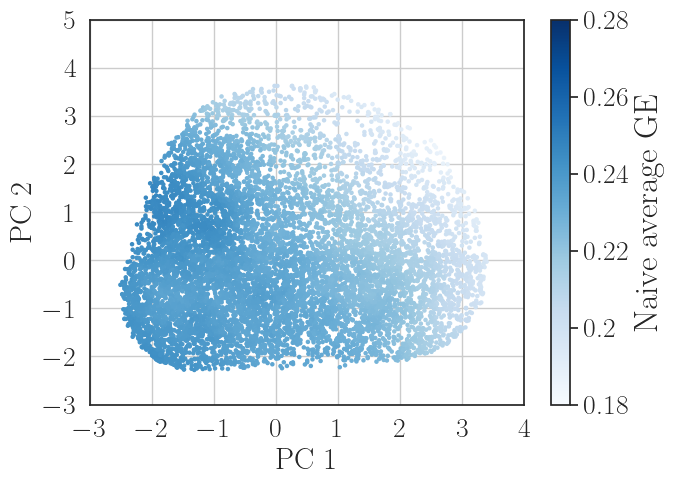

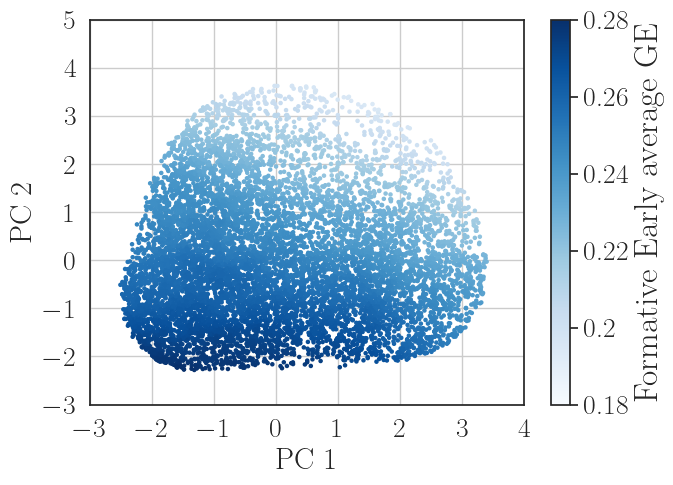

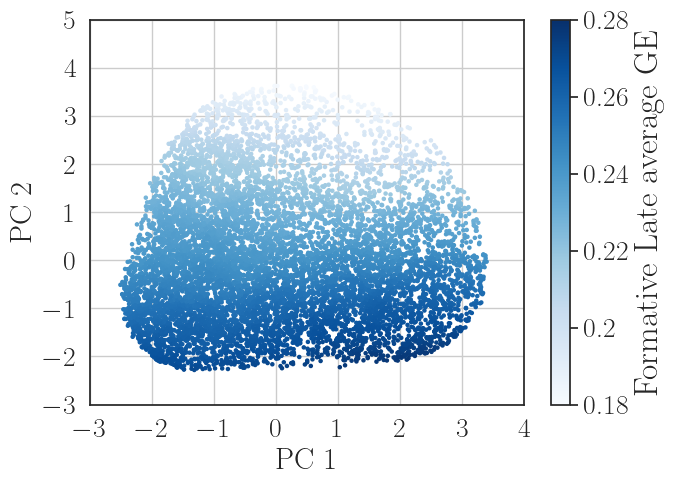

In [15]:
font = {'family': 'Avenir', 'size': 22}
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm

min_general = np.nanmin(result_df.values)
max_general = np.nanmax(result_df.values) 

plt.figure(figsize=(7,5))
scatter_pca = plt.scatter(principalDf_wt_input['PC1'], principalDf_wt_input['PC2'], 
                          c=result_df['Naive'], cmap='Blues', s=5, marker='o', alpha=1, label='WT Input GE', 
                          vmin=min_general, vmax=max_general)
cbar = plt.colorbar(scatter_pca)
cbar.set_label('Naive average GE', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ticks = np.linspace(min_general, max_general, num=6)
formatted_ticks = [f'{tick:.2g}' for tick in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(formatted_ticks)
plt.xlim([-3,4])
plt.ylim([-3,5])
plt.grid(True)
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.savefig(figs_path+'/PCA_CO_input_Naive_GE.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()


# Creazione del grafico scatter utilizzando la colormap viridis
plt.figure(figsize=(7,5))
scatter_pca = plt.scatter(principalDf_wt_input['PC1'], principalDf_wt_input['PC2'], 
                          c=result_df['Formative_early'], cmap='Blues', s=5, marker='o', alpha=1, label='WT Input GE',
                          vmin=min_general, vmax=max_general)
cbar = plt.colorbar(scatter_pca)
cbar.set_label('Formative Early average GE', fontsize=24)
cbar.ax.tick_params(labelsize=20)
cbar.set_ticks(ticks)
cbar.set_ticklabels(formatted_ticks)
plt.xlim([-3,4])
plt.ylim([-3,5])
plt.grid(True)
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
# plt.savefig(figs_path+'/PCA_CO_input_FormativeEarly_GE.svg', format='svg', transparent=True, bbox_inches='tight')

plt.show()

# Creazione del grafico scatter utilizzando la colormap viridis
plt.figure(figsize=(7,5))
scatter_pca = plt.scatter(principalDf_wt_input['PC1'], principalDf_wt_input['PC2'], 
                          c=result_df['Formative_late'], cmap='Blues', s=5, marker='o', alpha=1, label='WT Input GE',
                          vmin=min_general, vmax=max_general)
cbar = plt.colorbar(scatter_pca)
cbar.set_label('Formative Late average GE', fontsize=24)
cbar.ax.tick_params(labelsize=20)
cbar.set_ticks(ticks)
cbar.set_ticklabels(formatted_ticks)
plt.xlim([-3,4])
plt.ylim([-3,5])
plt.grid(True)
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
# plt.savefig(figs_path+'/PCA_CO_input_FormativeLate_GE.svg', format='svg', transparent=True, bbox_inches='tight')

plt.show()

